In [1]:
import mne
from mne.preprocessing import ICA
import pyprep # to find noisy channels
import os
import matplotlib.pyplot as plt
from scipy import stats

# Before therapy

In [2]:
filenames = ["2.Response Befor Therapy/"+i for i in os.listdir("2.Response Befor Therapy") if i[-4:]=='vhdr']
filenames

['2.Response Befor Therapy/NeoRec_2023-09-26_18-08-34.vhdr']

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


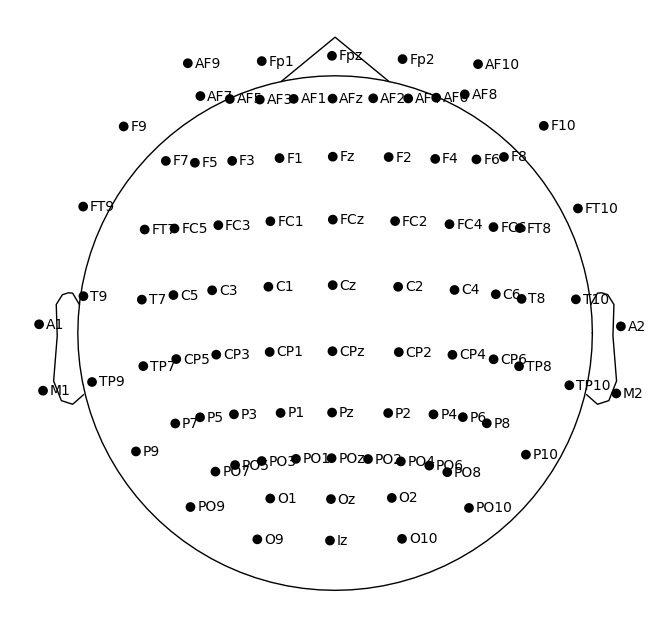

In [3]:
# Create basic electrode montage
montage = mne.channels.make_standard_montage('standard_1020')
montage.plot()
plt.show()

# Data preparation

In [4]:
# Load data and set montage
raw = mne.io.read_raw_brainvision(filenames[0])
raw.rename_channels({'Po3':'PO3', 'Po4':'PO4'})
raw.set_montage(montage)
raw.load_data()

# Find and interpolate noisy channels
nc = pyprep.find_noisy_channels.NoisyChannels(raw, do_detrend=False)
nc.find_bad_by_deviation(deviation_threshold=2) # OR use nc.find_all_bads()
bad_channels = nc.get_bads()
print(bad_channels)
raw.info['bads'] = bad_channels
raw = raw.copy().interpolate_bads()

# Filter data
raw.filter(l_freq=0.2, h_freq=12, verbose=False)

Extracting parameters from 2.Response Befor Therapy/NeoRec_2023-09-26_18-08-34.vhdr...
Setting channel info structure...
Reading 0 ... 133488  =      0.000 ...   266.976 secs...
['A1', 'Pz', 'Fp1', 'A2', 'Oz']
Interpolating bad channels
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 19 sensor positions
Interpolating 5 sensors


<RawBrainVision | NeoRec_2023-09-26_18-08-34.eeg, 24 x 133489 (267.0 s), ~24.5 MB, data loaded>

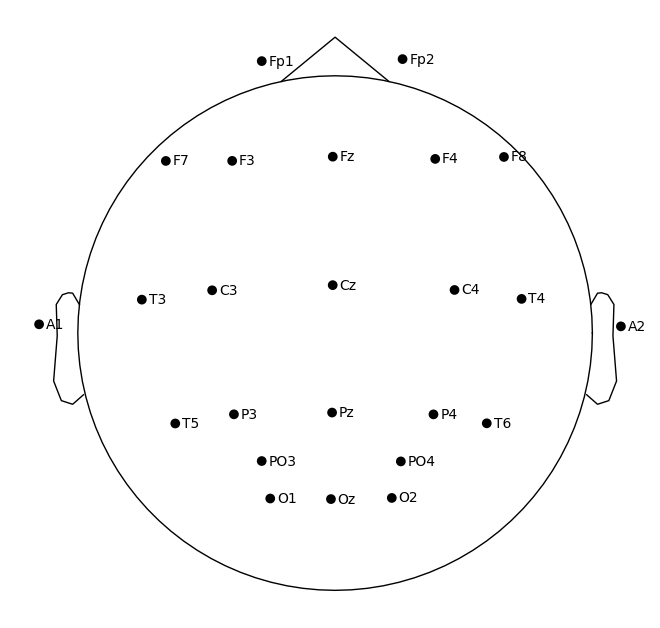

In [5]:
raw.get_montage().plot()
plt.show()

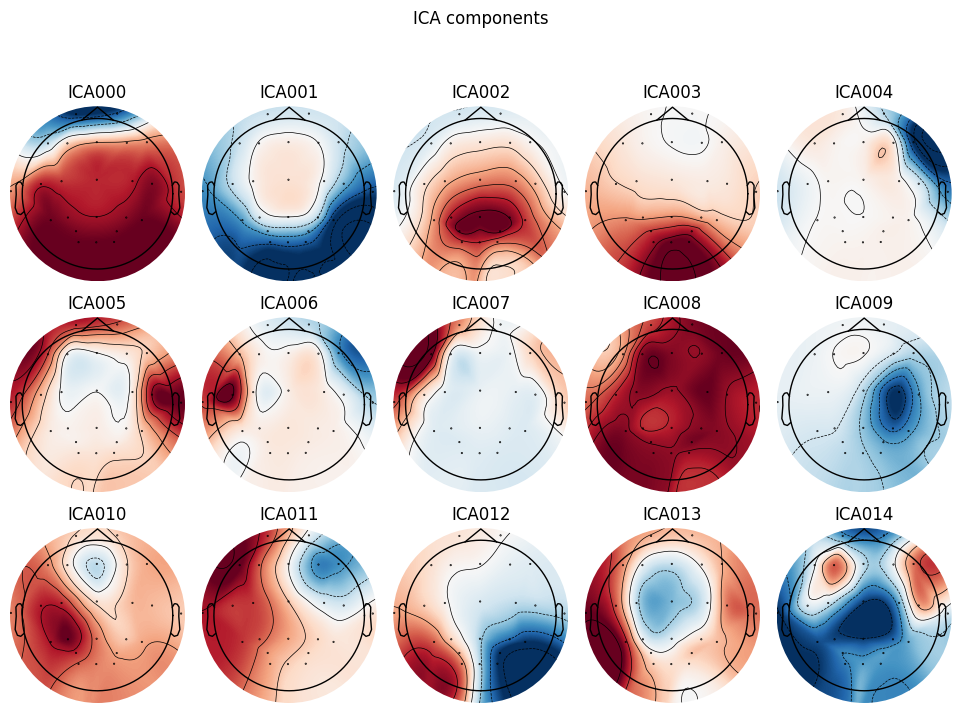

In [6]:
# Apply ICA to remove eyes component
# look for more info here https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html
ica = ICA(n_components=15, max_iter='auto', random_state=97, verbose=False)
ica.fit(raw, verbose=False)
ica.plot_components()
plt.show()

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 24 PCA components


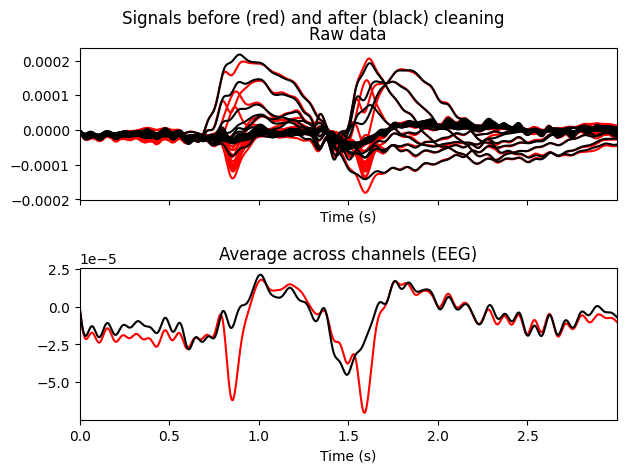

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 24 PCA components


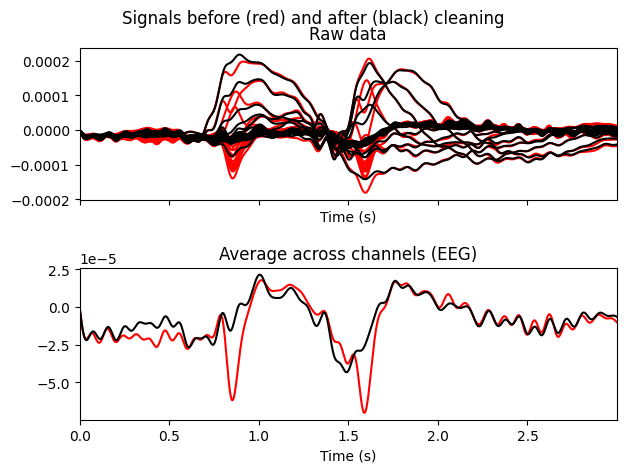

In [7]:
# First (and maybe second?) ICA component is eye component (blinking and moving artifacts)
# let's look closer what happend with signal when we remove them
ica.plot_overlay(raw, exclude=[0], picks="eeg")
ica.plot_overlay(raw, exclude=[0, 2], picks="eeg")
plt.show()

The first ICA component is blinking artefact, second is moving eyes from side to side - we can safely remove them both

In [8]:
ica.exclude = [0, 2]
raw = ica.apply(raw, verbose=False)

In [9]:
raw = raw.set_eeg_reference(['A1', 'A2']) # substract average of the ears

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


# Events extraction

Epoch - EEG recording around the event (for example from -0.5 to 1 sec around stimuli presentation)

In [10]:
events, event_id = mne.events_from_annotations(raw, verbose=False)
event_id = {
    'neutral': 10002,
    'smoking': 10003
}
events, event_id

(array([[     0,      0,  99999],
        [    61,      0,  10001],
        [  6917,      0,  10003],
        [  8173,      0,  10003],
        [  9423,      0,  10003],
        [ 10676,      0,  10002],
        [ 11926,      0,  10003],
        [ 13179,      0,  10003],
        [ 14429,      0,  10002],
        [ 15680,      0,  10002],
        [ 16928,      0,  10002],
        [ 18178,      0,  10003],
        [ 19428,      0,  10003],
        [ 20678,      0,  10002],
        [ 21928,      0,  10002],
        [ 23177,      0,  10003],
        [ 24427,      0,  10003],
        [ 25677,      0,  10003],
        [ 26926,      0,  10003],
        [ 28177,      0,  10002],
        [ 29426,      0,  10002],
        [ 30676,      0,  10002],
        [ 31929,      0,  10002],
        [ 33180,      0,  10002],
        [ 34430,      0,  10003],
        [ 35678,      0,  10002],
        [ 36928,      0,  10003],
        [ 38178,      0,  10002],
        [ 39428,      0,  10003],
        [ 4067

In [11]:
threshold = 250e-6
tmin, tmax = -0.5, 1.  # in s
baseline = (-0.5, 0)
epochs = mne.Epochs(
    raw, events=events,
    event_id=event_id, tmin=tmin,
    tmax=tmax, baseline=baseline, verbose=False, reject={'eeg':threshold}, event_repeated='drop')

In [12]:
epochs

Number of events,100
Events,neutral: 50smoking: 50
Time range,-0.500 – 1.000 sec
Baseline,-0.500 – 0.000 sec


No projector specified for this dataset. Please consider the method self.add_proj.


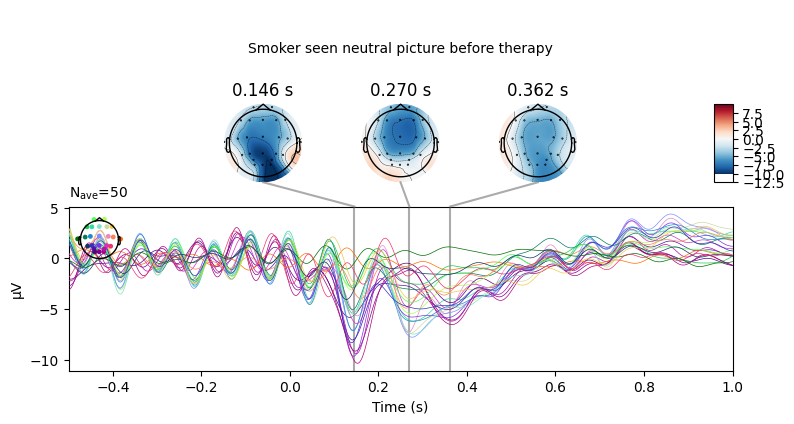

In [13]:

title = f'Smoker seen neutral picture before therapy'
epochs['neutral'].average().plot_joint(title=title)
plt.show()

No projector specified for this dataset. Please consider the method self.add_proj.


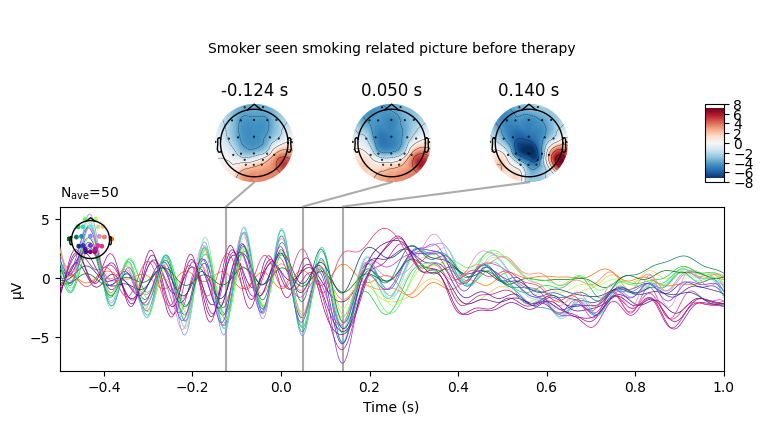

In [14]:
title = f'Smoker seen smoking related picture before therapy'
epochs['smoking'].average().plot_joint(title=title)
plt.show()

In [15]:
diff = (epochs['smoking'].average().get_data() - epochs['neutral'].average().get_data())[None]
diff_evoked = mne.EpochsArray(diff, epochs.info, tmin=-0.5).average()

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


No projector specified for this dataset. Please consider the method self.add_proj.


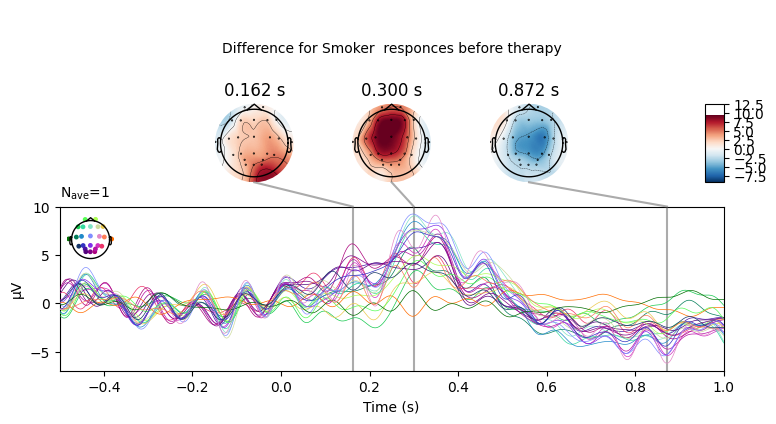

In [16]:
title = f'Difference for Smoker  responces before therapy'
diff_evoked.plot_joint(title=title) 
plt.show()

In [17]:
selected_e = [raw.ch_names.index(i) for i in ["O1", "Oz", "O2", "P3", "Pz", "P4", "PO3", "PO4"]]
av_diff = diff[0, selected_e, int(0.5 * 500 + 0.18 * 500):int(0.5 * 500 + 0.22 * 500)]

In [18]:
before = av_diff.mean()

In [19]:
epochs['smoking'].get_data().shape # it is numpy.array, you may slice/average etc - do any statistics you want
# the shape of array is (n_epochs, n_electrodes, n_times)

Using data from preloaded Raw for 50 events and 751 original time points ...
0 bad epochs dropped


(50, 24, 751)

# After therapy

In [20]:
filenames = ["5.Response After Therapy/"+i for i in os.listdir("5.Response After Therapy") if i[-4:]=='vhdr']
filenames

['5.Response After Therapy/NeoRec_2023-09-26_18-28-26.vhdr']

4 duplicate electrode labels found:
T7/T3, T8/T4, P7/T5, P8/T6
Plotting 90 unique labels.


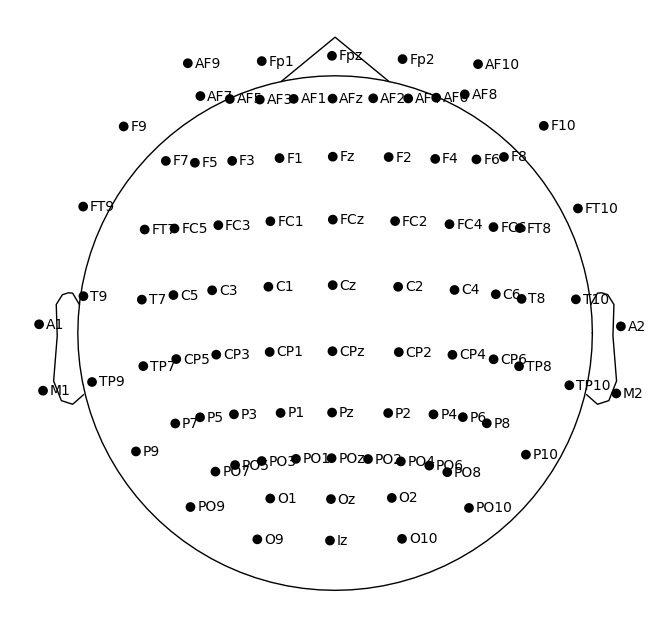

In [21]:
# Create basic electrode montage
montage = mne.channels.make_standard_montage('standard_1020')
montage.plot()
plt.show()

In [22]:
# Load data and set montage
raw = mne.io.read_raw_brainvision(filenames[0])
raw.rename_channels({'Po3':'PO3', 'Po4':'PO4'})
raw.set_montage(montage)
raw.load_data()

# Find and interpolate noisy channels
nc = pyprep.find_noisy_channels.NoisyChannels(raw, do_detrend=False)
nc.find_bad_by_deviation(deviation_threshold=2) # OR use nc.find_all_bads()
bad_channels = nc.get_bads()
print(bad_channels)
raw.info['bads'] = bad_channels
raw = raw.copy().interpolate_bads()

# Filter data
raw.filter(l_freq=0.2, h_freq=12, verbose=False)

Extracting parameters from 5.Response After Therapy/NeoRec_2023-09-26_18-28-26.vhdr...
Setting channel info structure...
Reading 0 ... 131643  =      0.000 ...   263.286 secs...
['A2']
Interpolating bad channels
    Automatic origin fit: head of radius 95.8 mm
Computing interpolation matrix from 23 sensor positions
Interpolating 1 sensors


<RawBrainVision | NeoRec_2023-09-26_18-28-26.eeg, 24 x 131644 (263.3 s), ~24.1 MB, data loaded>

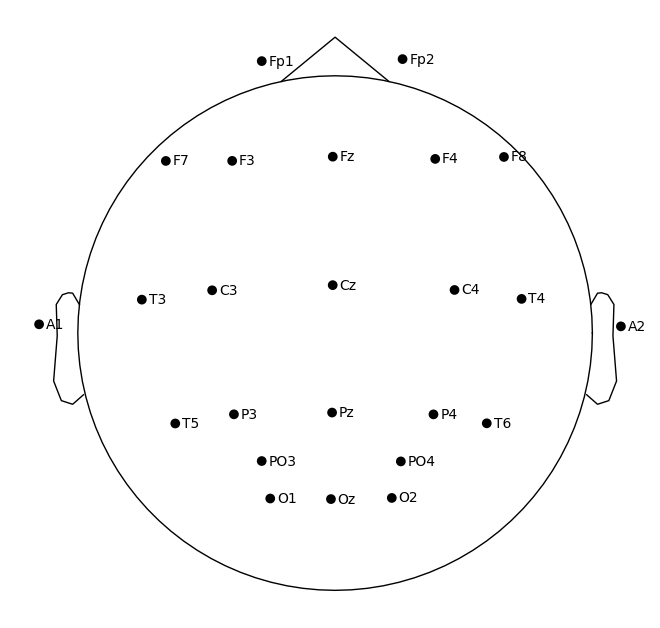

In [23]:
raw.get_montage().plot()
plt.show()

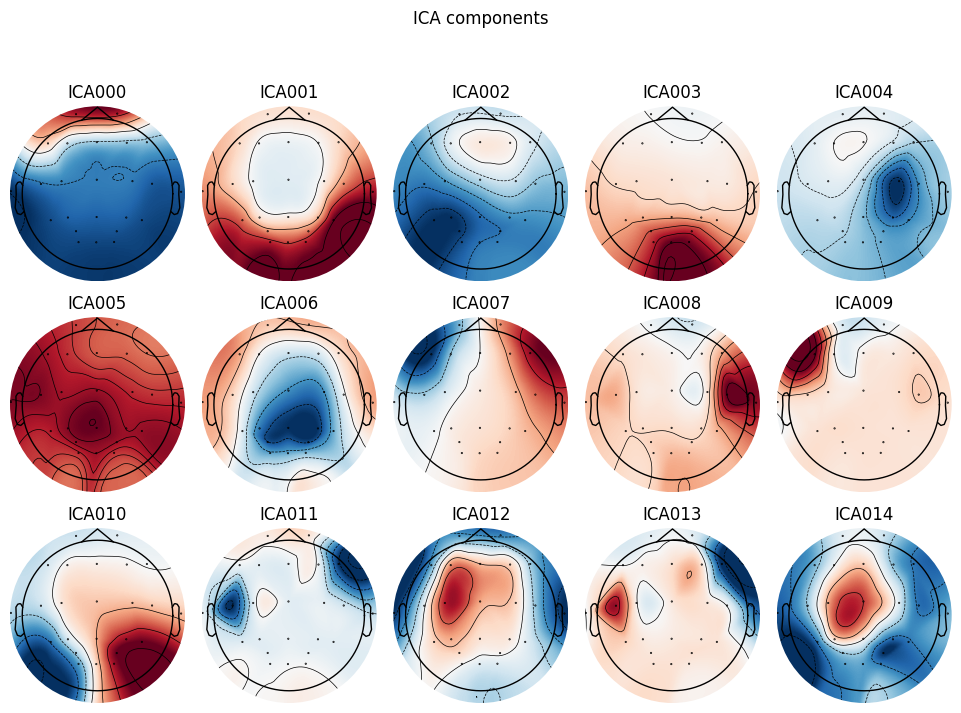

In [24]:
# Apply ICA to remove eyes component
# look for more info here https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html
ica = ICA(n_components=15, max_iter='auto', random_state=97, verbose=False)
ica.fit(raw, verbose=False)
ica.plot_components()
plt.show()

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 1 ICA component
    Projecting back using 24 PCA components


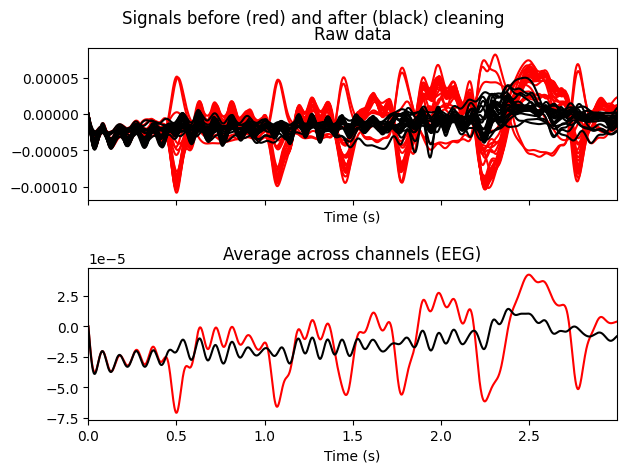

Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 24 PCA components


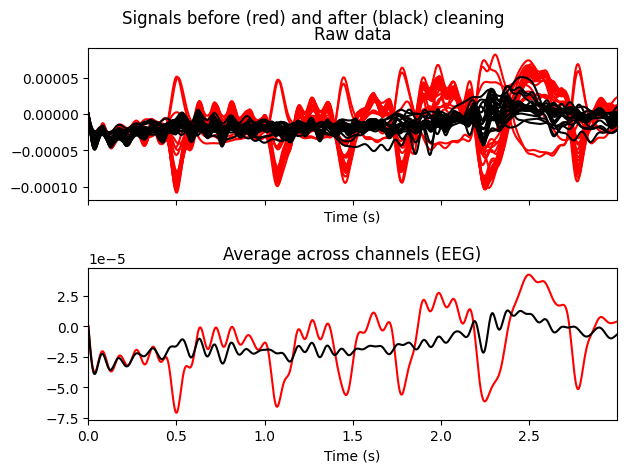

In [25]:
# First (and maybe second?) ICA component is eye component (blinking and moving artifacts)
# let's look closer what happend with signal when we remove them
ica.plot_overlay(raw, exclude=[0], picks="eeg")
ica.plot_overlay(raw, exclude=[0, 2], picks="eeg")
plt.show()

In [26]:
ica.exclude = [0, 2]
raw = ica.apply(raw, verbose=False)

In [27]:
raw = raw.set_eeg_reference(['A1', 'A2']) # substract average of the ears

EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


In [28]:
events, event_id = mne.events_from_annotations(raw, verbose=False)
event_id = {
    'neutral': 10002,
    'smoking': 10003
}
events, event_id

(array([[     0,      0,  99999],
        [    80,      0,  10001],
        [  4554,      0,  10002],
        [  5812,      0,  10002],
        [  7062,      0,  10003],
        [  8311,      0,  10003],
        [  9562,      0,  10002],
        [ 10811,      0,  10003],
        [ 12061,      0,  10003],
        [ 13311,      0,  10003],
        [ 14561,      0,  10002],
        [ 15810,      0,  10003],
        [ 17060,      0,  10002],
        [ 18310,      0,  10003],
        [ 19560,      0,  10003],
        [ 20809,      0,  10003],
        [ 22059,      0,  10002],
        [ 23309,      0,  10003],
        [ 24559,      0,  10003],
        [ 25809,      0,  10002],
        [ 27058,      0,  10002],
        [ 28308,      0,  10002],
        [ 29559,      0,  10002],
        [ 30811,      0,  10003],
        [ 32062,      0,  10002],
        [ 33311,      0,  10002],
        [ 34561,      0,  10002],
        [ 35815,      0,  10003],
        [ 37063,      0,  10002],
        [ 3831

In [29]:
threshold = 250e-6
tmin, tmax = -0.5, 1.  # in s
baseline = (-0.5, 0)
epochs = mne.Epochs(
    raw, events=events,
    event_id=event_id, tmin=tmin,
    tmax=tmax, baseline=baseline, verbose=False, reject={'eeg':threshold}, event_repeated='drop')

In [30]:
epochs

Number of events,100
Events,neutral: 50smoking: 50
Time range,-0.500 – 1.000 sec
Baseline,-0.500 – 0.000 sec


No projector specified for this dataset. Please consider the method self.add_proj.


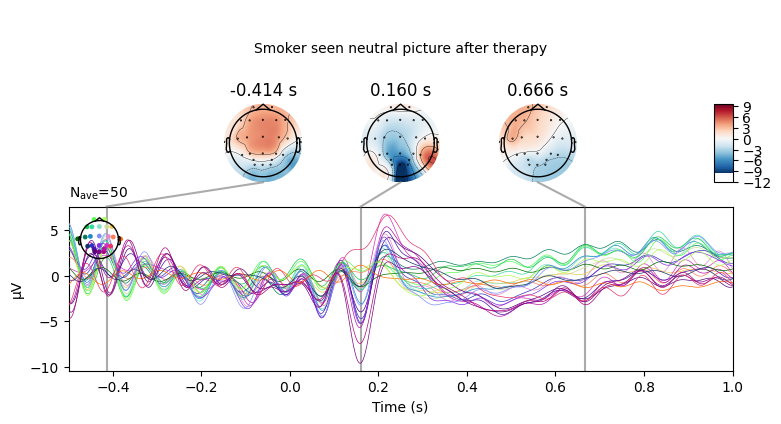

In [31]:
title = f'Smoker seen neutral picture after therapy'
epochs['neutral'].average().plot_joint(title=title)
plt.show()

No projector specified for this dataset. Please consider the method self.add_proj.


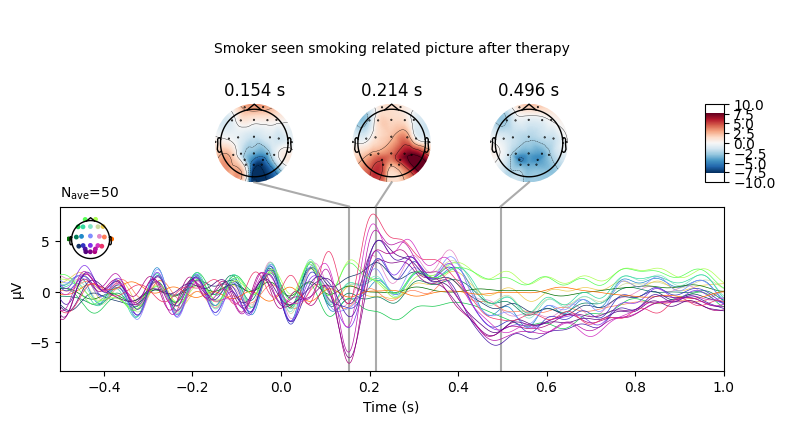

In [32]:
title = f'Smoker seen smoking related picture after therapy'
epochs['smoking'].average().plot_joint(title=title)
plt.show()

In [33]:
diff = (epochs['smoking'].average().get_data() - epochs['neutral'].average().get_data())[None]
diff_evoked = mne.EpochsArray(diff, epochs.info, tmin=-0.5).average()

Not setting metadata
1 matching events found
No baseline correction applied
0 projection items activated


No projector specified for this dataset. Please consider the method self.add_proj.


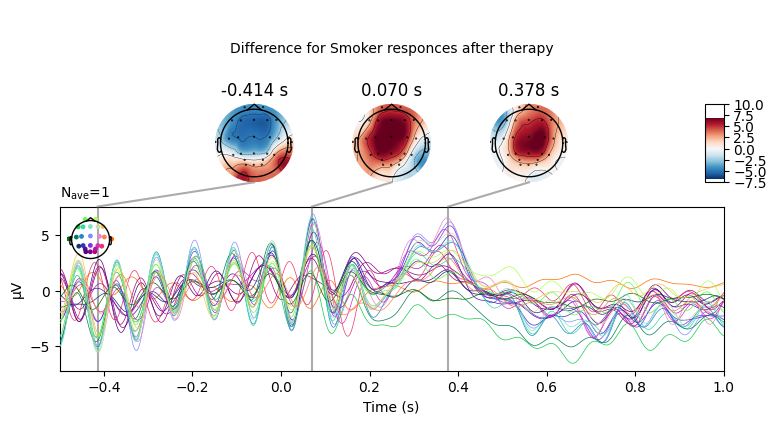

In [34]:
title = f'Difference for Smoker responces after therapy'
diff_evoked.plot_joint(title=title) 
plt.show()

In [35]:
selected_e = [raw.ch_names.index(i) for i in ["O1", "Oz", "O2", "P3", "Pz", "P4", "PO3", "PO4"]]
av_diff = diff[0, selected_e, int(0.5 * 500 + 0.18 * 500):int(0.5 * 500 + 0.22 * 500)]

In [36]:
after = av_diff.mean()

In [37]:
import numpy as np
(max(np.abs(after), np.abs(before)) - min(np.abs(after), np.abs(before)))/max(np.abs(after), np.abs(before)) * 100

63.94619359468042

In [38]:
after - before

-2.08094989312403e-06

In [39]:
epochs['smoking'].get_data().shape # it is numpy.array, you may slice/average etc - do any statistics you want
# the shape of array is (n_epochs, n_electrodes, n_times)

Using data from preloaded Raw for 50 events and 751 original time points ...
0 bad epochs dropped


(50, 24, 751)

# A bit of statistics

In [43]:
(39+11+64)/3

38.0

In [40]:
(0.2 + 0.5) * 500, (0.25 + 0.5) * 500 # thats timestamps around the peak in epochs

(350.0, 375.0)

In [41]:
peak_smoke = epochs['smoking'].copy().load_data().pick_channels(['O1', 'Oz', 'O2', 'PO3', 'PO4'], ordered=True).get_data()[:, :, 350:375].mean((1, 2)) # average across chosen channels and around peak in time
peak_neutral = epochs['neutral'].copy().load_data().pick_channels(['O1', 'Oz', 'O2', 'PO3', 'PO4'], ordered=True).get_data()[:, :, 350:375].mean((1, 2))

Using data from preloaded Raw for 50 events and 751 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 50 events and 751 original time points ...
0 bad epochs dropped


In [42]:
stats.mannwhitneyu(peak_smoke, peak_neutral)

MannwhitneyuResult(statistic=1352.0, pvalue=0.4841004864411871)